In [48]:
import typing
import time
import numpy as np
from sympy import integer_nthroot
from bisect import bisect_left, bisect_right
from math import isqrt, gcd, log2, log, ceil, floor, sqrt
from random import randint
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import json
import sys


In [54]:
primes = np.load("primes.npy").astype(np.uint32)
np.savetxt("small_primes.txt", primes, fmt="%u")

In [ ]:
def sieveTo(n):
    primality = [False,False]+[True for c in range(n-1)]
    for i in range(2, isqrt(n)+1):
        if not primality[i]:
            continue
        for j in range(i*i, n + 1, i):
            primality[j] = False
    return [p for p in range(len(primality)) if primality[p]]

def is_prime_naive(n, small_primes, offsets, B=1000000, lcm=210):
    if n < 2:
        return False
    if n <= B:
        i = bisect_left(small_primes, n)
        if i < len(small_primes) and small_primes[i] == n:
            return True
    S = isqrt(n)
    if S <= B:
        idx = bisect_right(small_primes, S)
        for p in small_primes[:idx]:
            if n % p == 0:
                return False
        return True
    
    for p in small_primes:
        if n % p == 0:
            return False
    L = (B // lcm) * lcm
    if L <= B:
        L += lcm
    while True:
        for r in offsets:
            q = L + r
            if q > S:
                return True
            if n % q == 0:
                return False
        L += lcm

In [ ]:
small_primes = tuple(int(x) for x in np.load("primes.npy"))
WHEEL_OFFSETS_210 = [1,   11,  13,  17,  19,  23,  29,  31, 37,   41,  43,  47,  49,  53,  59,  61,
                        67,   71,  73,  77,  79,  83,  89,  91, 97,  101, 103, 107, 109, 113, 119, 121,
                        127,  131, 133, 137, 139, 143, 149, 151, 157,  161, 163, 167, 169, 173, 179, 181,
                        187,  191, 193, 197, 199, 203, 209]

In [6]:
t1 = time.time()
p = is_prime_naive(n=999983, small_primes=small_primes, offsets=WHEEL_OFFSETS_210)
t2 = time.time()
print(t2-t1, p)

t1 = time.time()
p = is_prime_naive(n=999999999989, small_primes=small_primes, offsets=WHEEL_OFFSETS_210)
t2 = time.time()
print(t2-t1, p)

t1 = time.time()
p = is_prime_naive(n=9223372036854775783, small_primes=small_primes, offsets=WHEEL_OFFSETS_210)
t2 = time.time()
print(t2-t1, p)

5.412101745605469e-05 True
0.003057718276977539 True
92.0485291481018 True


In [7]:
def power_test(n, small_primes):
    L = n.bit_length() - 1
    idx = bisect_right(small_primes, L)
    for k in small_primes[:idx]:
        if integer_nthroot(n,k)[1]:
            return True
    return False

def is_prime_prob(n, small_primes, rounds=10):
    if n < 4:
        return (n == 2 or n == 3)
    if power_test(n, small_primes):
        return False
    lowbit = (n-1) & -(n-1)
    s = lowbit.bit_length() - 1
    t = (n-1) >> s
    for _ in range(rounds):
        a = randint(2,n-2)
        if gcd(a,n) > 1:
            return False
        sequence = [pow(a, (1 << i) * t, n) for i in range(0, s+1)]
        if sequence[0] == 1 or sequence[0] == n-1:
            continue
        for i in range(1, s+1):
            if sequence[i] == n-1:
                break
        else:
            return False
    return True

In [8]:
t1 = time.time()
t = power_test(9223372036854775783, small_primes)
t2 = time.time()
print(t2-t1, t)

t1 = time.time()
p = is_prime_prob(n=999983, small_primes=small_primes)
t2 = time.time()
print(t2-t1, p)

t1 = time.time()
p = is_prime_prob(n=999999999989, small_primes=small_primes)
t2 = time.time()
print(t2-t1, p)

t1 = time.time()
p = is_prime_prob(n=9223372036854775783, small_primes=small_primes)
t2 = time.time()
print(t2-t1, p)

t1 = time.time()
p = is_prime_prob(n=170141183460469231731687303715884105727, small_primes=small_primes)
t2 = time.time()
print(t2-t1, p)

t1 = time.time()
p = is_prime_prob(n=66879465661348111229871989287968040993513351195484998191057052014006844134449, small_primes=small_primes)
t2 = time.time()
print(t2-t1, p)

0.0001862049102783203 False
0.00013208389282226562 True
0.00024390220642089844 True
0.000308990478515625 True
0.0008351802825927734 True
0.009474754333496094 True


In [9]:
def polyMul(A, B, r, n):
    C = [0]*r
    for i in range(r):
        if A[i] == 0:
            continue
        for j in range(r):
            if B[j] == 0:
                continue
            k = (i + j) % r
            C[k] = (C[k] + (A[i] * B[j])) % n
    return C

def polyPow(G, exp, r, N):
    acc  = [1] + [0]*(r-1)
    base = G[:]
    e = exp
    while e > 0:
        if (e & 1) == 1:
            acc = polyMul(acc, base, r, N)
        base = polyMul(base, base, r, N)
        e   = e >> 1
    return acc

def o(r, n, B):
    residue = 1
    for _ in range(1, B + 1):
        residue = (residue * n) % r
        if residue == 1:
            return True
    return False 

def totient(r, small_primes):
    phi = r
    idx = bisect_right(small_primes, isqrt(r))
    for p in small_primes[:idx]:
        phi -= phi//p
        while r % p == 0:
            r //= p
    if r > 1:
        phi -= phi // r
    return phi

def is_prime_aks(n, small_primes):
    if n <= 2 or power_test(n, small_primes):
        return (n == 2)
    
    M = ceil(log2(n) ** 5)
    B = floor(log2(n) ** 2)
    for r in range(2, M+1):
        if 1 < gcd(r, n) < n:
            return False
        if r > B and not o(r, n, B):
            break
    
    if n <= r:
        return True

    for a in range(1, floor(sqrt(totient(r, small_primes=small_primes))*log2(n))+1):
        a_mod = a % n
        G = [a_mod] + [1] + ([0] * (r-2))
        result = polyPow(G, n, r, n) 
        target = [0]*r
        target[n % r] = 1
        target[0] = a_mod
        if target != result:
            return False
    
    return True

In [10]:
t1 = time.time()
p = is_prime_aks(n=999983, small_primes=small_primes)
t2 = time.time()
print(t2-t1, p)

69.497967004776 True


In [ ]:
def is_prime(n, small_primes, small_primes_set):
    if n < 1e6:
        return (n in small_primes_set)
    if power_test(n, small_primes):
        return False
    lowbit = (n-1) & -(n-1)
    s = lowbit.bit_length() - 1
    t = (n-1) >> s
    if n.bit_length() < 64:
        witnesses = (2,325,9375,28178,450775,9780504,1795265022)
    else:
        witnesses = range(2, floor(2*(log(n) ** 2)) + 1)
    for a in witnesses:
        if gcd(a,n) > 1:
            return False
        x = pow(a, t, n)
        if x == 1 or x == n-1:
            continue
        for _ in range(s-1):
            x = (x * x) % n
            if x == n-1:
                break
        else:
            return False
    return True

In [12]:
small_primes_set = set(small_primes)

t1 = time.time()
p = is_prime(n=999983, small_primes=small_primes, small_primes_set=small_primes_set)
t2 = time.time()
print(t2-t1, p)

t1 = time.time()
p = is_prime(n=999999999989, small_primes=small_primes, small_primes_set=small_primes_set)
t2 = time.time()
print(t2-t1, p)

t1 = time.time()
p = is_prime(n=9223372036854775783, small_primes=small_primes, small_primes_set=small_primes_set)
t2 = time.time()
print(t2-t1, p)

t1 = time.time()
p = is_prime(n=170141183460469231731687303715884105727, small_primes=small_primes, small_primes_set=small_primes_set)
t2 = time.time()
print(t2-t1, p)

t1 = time.time()
p = is_prime(n=66879465661348111229871989287968040993513351195484998191057052014006844134449, small_primes=small_primes, small_primes_set=small_primes_set)
t2 = time.time()
print(t2-t1, p)

5.2928924560546875e-05 True
0.0002560615539550781 True
0.00015807151794433594 True
0.5943751335144043 True
11.17274808883667 True


In [22]:
def primality_complexity(func, N, data=None):
    if data:
        test_primes = data
    else:
        print(f"Beginning sieveTo({N})...")
        test_primes = sieveTo(N)
        print(f"Found {len(test_primes)} primes.")

    times = []
    print("Collecting times...")
    for i, p in enumerate(test_primes):
        print(str(i)+', ', end='')
        t1 = time.time()
        func(n=p)
        t2 = time.time()
        times.append(t2 - t1)

    print("\nFinished collecting times.")
    return times, test_primes

def graph_complexity(times, test_primes, dpts=1000, log=False):
    delta = len(times) // dpts
    T = [mean(times[i : i + delta]) for i in range(0, len(times), delta)]
    P = [mean(test_primes[i : i + delta]) for i in range(0, len(test_primes), delta)]
    print("Finished concat.")
    print("Graphing...")

    fig = plt.figure(figsize=(10, 6), dpi=200)
    plt.scatter(P, T, marker='.', s=1, color='k')
    if log:
        plt.xscale('log', base=2)
        plt.yscale('log', base=2)
    xmin, xmax = min(P), max(P)
    ymin, ymax = min(T), max(T)
    print(xmin, xmax, ymin, ymax)
    
    if log:
        log2_min = np.log2(float(xmin))
        log2_max = np.log2(float(xmax))
        ticks_log2 = np.linspace(log2_min, log2_max, 10)
        xticks = 2 ** ticks_log2
        xtick_labels = [f"$2^{{{int(round(np.log2(float(x))))}}}$" for x in xticks]
        plt.xticks(xticks, xtick_labels)
    else:
        xticks = np.linspace(xmin, xmax, 10)
        def round_highest(x):
            if x == 0:
                return 0
            mag = 10 ** int(np.floor(np.log10(abs(float(x)))))
            return int(round(x / mag) * mag)
        xtick_labels = [str(round_highest(x)) for x in xticks]
        plt.xticks(xticks, xtick_labels)
    if log:
       log2_ymin = np.log2(float(ymin))
       log2_ymax = np.log2(float(ymax))
       yticks = 2 ** np.linspace(log2_ymin, log2_ymax, 10)
       ytick_labels = [f"$2^{{{int(round(np.log2(float(y))))}}}$" for y in yticks]
       plt.yticks(yticks, ytick_labels)
    else:
       yticks = np.linspace(ymin, ymax, 10)
       ytick_labels = [format(y, '.3e') for y in yticks]
       plt.yticks(yticks, ytick_labels)
    plt.tick_params(axis='both', direction='in')
    plt.xlabel('n')
    plt.ylabel('Average Time (sec)')
    plt.tight_layout()
    plt.show()

In [23]:
with open("large_prime_dataset.json", 'r') as f:
    raw = json.load(f)
data =  {int(k): v for k, v in raw.items()}

In [30]:
primes_64_bit = [(2**n - k) for n in range(8, 64) for k in data[n]]
primes_256_bit = [(2**n - k) for n in range(8, 257) for k in data[n]]

print(len(primes_64_bit), max(primes_64_bit))
print(len(primes_256_bit), max(primes_256_bit))

560 9223372036854775783
2490 115792089237316195423570985008687907853269984665640564039457584007913129639747


In [31]:
data_64 = primes_64_bit
data_256 = [primes_256_bit[i] for i in range(0, len(primes_256_bit), 5)]
print(len(data_64), len(data_256))

times_64 = primality_complexity(lambda n : is_prime(n, small_primes=small_primes, small_primes_set=small_primes_set), 0, data_64)
times_256 = primality_complexity(lambda n : is_prime(n, small_primes=small_primes, small_primes_set=small_primes_set), 0, data_256)

560 498
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

Finished concat.
Graphing...
197 9223372036854775783 2.220446049250313e-16 0.0004217624664308861


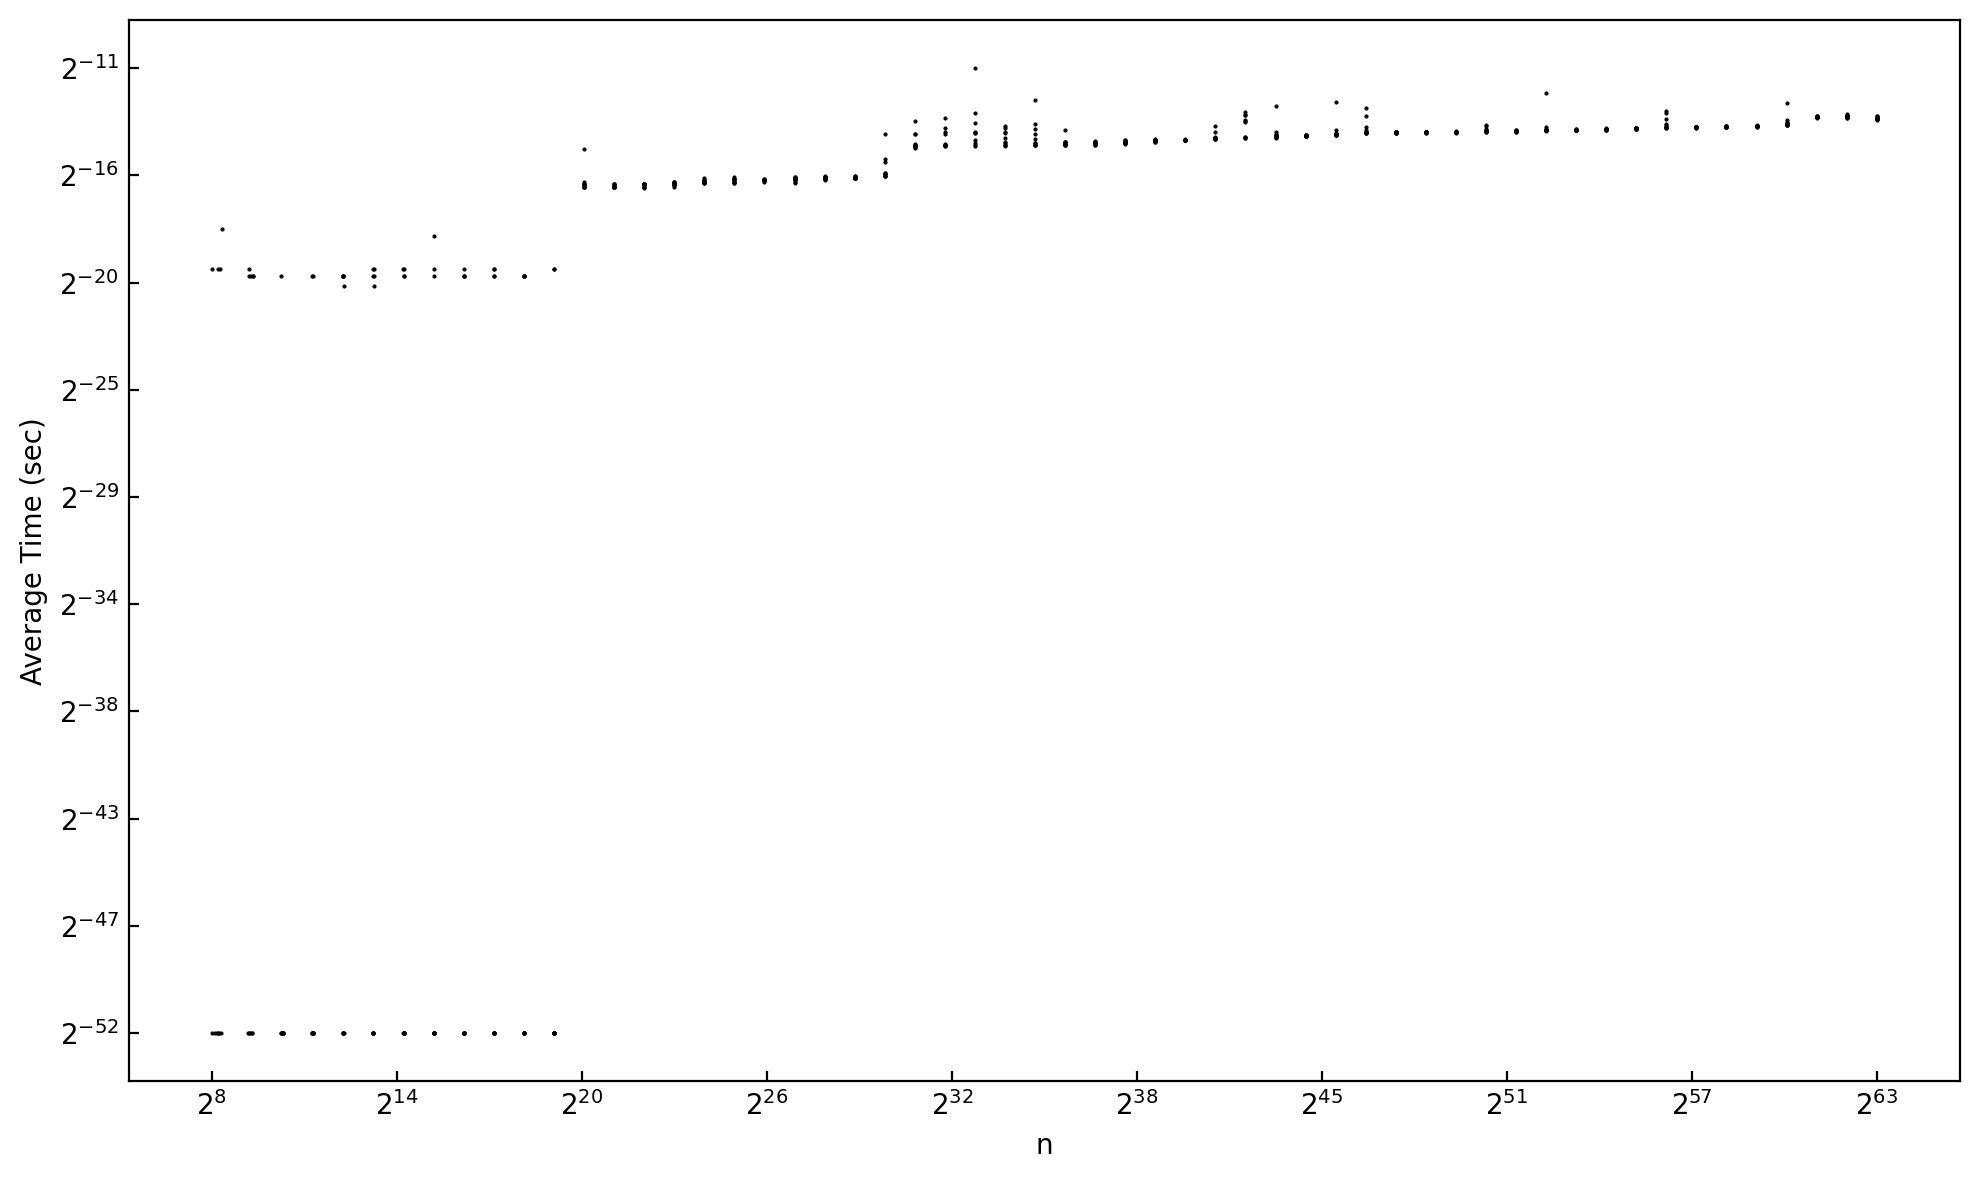

In [40]:
graph_complexity([(t+sys.float_info.epsilon) for t in times_64[0]], times_64[1], dpts=560, log=True)

Finished concat.
Graphing...
227 115792089237316195423570985008687907853269984665640564039457584007913129639747 2.220446049250313e-16 11.949983835220337


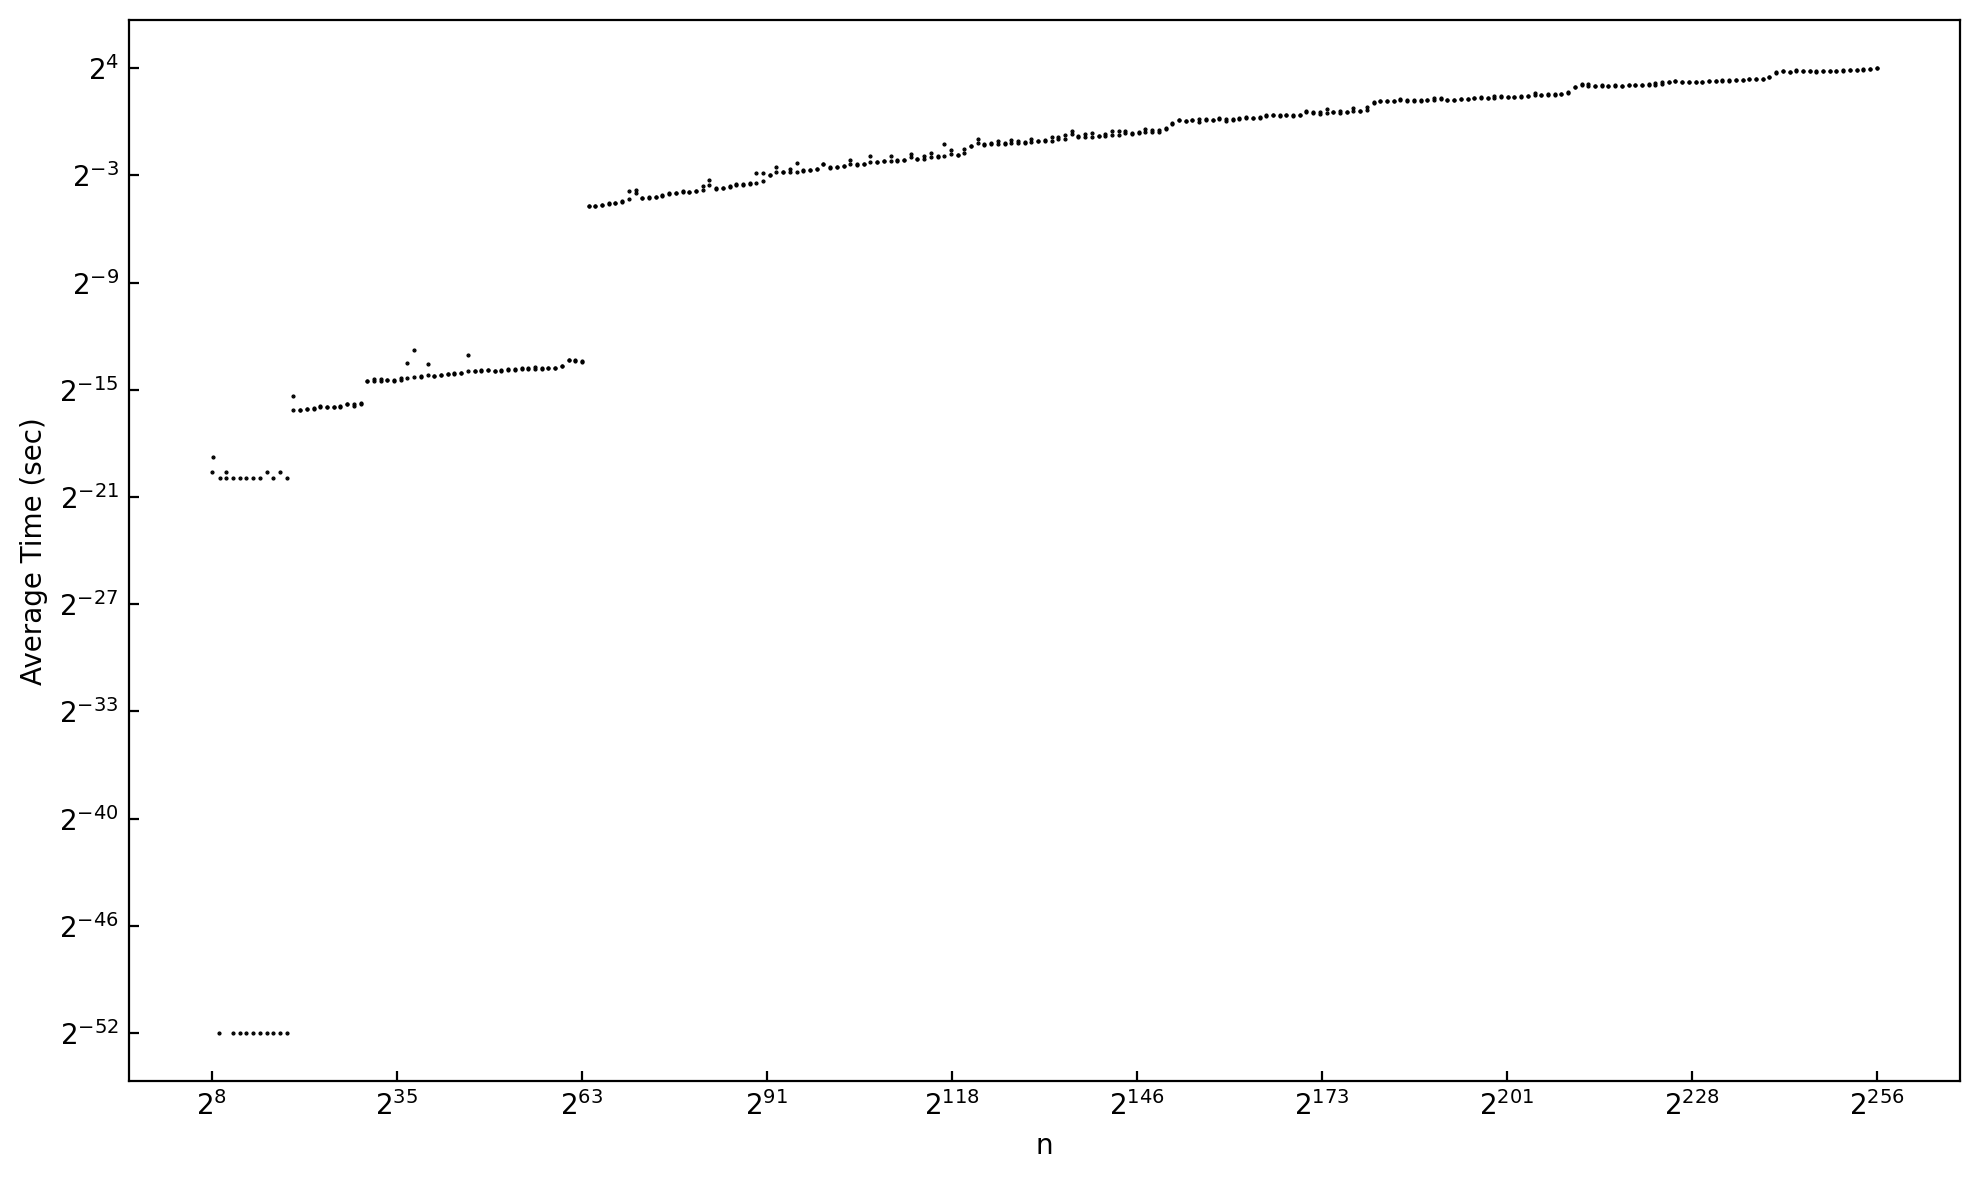

In [41]:
graph_complexity([(t+sys.float_info.epsilon) for t in times_256[0]], times_256[1], dpts=498, log=True)